# 全天日射量の直散分離

全天日射量を直達日射量と天空日射量に分離する方法について。

なぜ分離？

* 各方位の窓や壁に入射する全日射量を知るために、その分離後、方位・傾斜角によって再合成する必要がある。
* 気象庁のデータでは全天日射のみ記録されている。


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import matplotlib.dates as mdates
from datetime import datetime

## 気象庁の生データを読み込む

In [2]:
data = pd.read_csv("weather/s47772_610.csv", header=None, encoding="SHIFT-JIS", skiprows=6, names=["Date", "J", "QI", "QL"])

### 読み込んだ日射量のうち最初の1日を表示

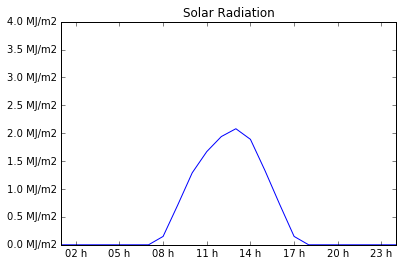

In [3]:
x = [datetime.strptime(d, '%Y/%m/%d %H:%M:%S') for d in data.Date]
plt.title('Solar Radiation')
plt.plot(x, data.J)
plt.xlim(x[0], x[23])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%1.1f MJ/m2'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H h'))

### 太陽高度hの計算をしておく

(SolarLocation.ipynb より)

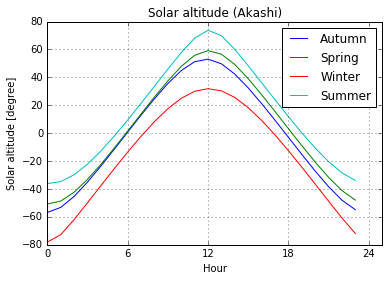

In [4]:
from math import cos, sin, asin, atan, atan2, pi, ceil, floor, sqrt, pow

def get_decl(d):
    omega = 2.0 * pi / 365
    J = d + 0.5
    decl = 0.33281 - 22.984 * cos(omega*J) - 0.34990*cos(2.0*omega*J) - 0.13900 * cos(3.0*omega+J) + 3.7872 * sin(omega*J) + 0.03250*sin(2.0*omega*J) + 0.07187 * sin(3.0*omega*J)
    return decl

def get_et(d):
    omega = 2.0 * pi / 365
    J = d
    et = 0.0072 * cos(omega*J) - 0.0528*cos(2.0*omega*J) - 0.0012*cos(3.0*omega*J) - 0.1229*sin(omega*J) - 0.1565*sin(2.0*omega*J) - 0.0041*sin(3.0*omega*J)
    return et

def get_hourangle(d, Tm, longtitude):
    tm = Tm + (longtitude - 135)/15
    th = tm + get_et(d)
    t = 15 * th - 180
    return t

def get_h(d, Ts, longtitude, latitude):
    decl_rad = get_decl(d) * pi / 180
    t_rad = get_hourangle(d, Ts, longtitude) * pi / 180
    lat_rad = latitude * pi / 180
    h = asin(sin(lat_rad) * sin(decl_rad) + cos(lat_rad) * cos(decl_rad) * cos(t_rad))
    h *= 180 / pi
    return h

hours = [i/4 for i in range(24*4)]
seasons = {"Winter":0, "Spring":90, "Summer":210, "Autumn":270}
for label, d in seasons.items():
    plt.plot(hours, [get_h(ceil(h/24)+d, h%24, 135, 35) for h in hours], label=label)

plt.title("Solar altitude (Akashi)")
plt.xlabel("Hour")
plt.ylabel("Solar altitude [degree]")
plt.xticks([0,6,12,18,24])
plt.grid()
plt.legend(loc="upper right")
plt.show()

## 直散分離法

水平面全天日射量, 法線面直達日射量,　水平面天空日射量には次の関係式が成り立つ。

$I_G = I_b sin h + I_d$

ここで、

* $I_G$ : 水平全天日射量 [MJ/m2h]
* $I_h$ : 法線面直達日射量 [MJ/m2h]
* $I_d$ : 水平面全天日射量 [MJ/m2h]
* $h$ : 太陽高度角[°]

水平面全天日射量$I_G$は気象庁からデータを得ることができるので、 
法線面直達日射量$I_h$ または 水平面天空日射量$I_d$を求めることができれば、
いずれも値も求めることができる。

### Erbs モデル

Erbsモデルは晴天・曇天を問わず水平面全天日射から水平面天空日射を求める。

$K_t <= 0.22 $ の場合、$I_d = I_G \cdot (1.0 - 0.09 \cdot K_t)$

$0.22 < K_t <= 0.80$ の場合、 $I_d = I_G \cdot \sum^{4}_{i=0} k_i K_t$

$K_t > 0.80 $ の場合、 $I_d = 0.165 \cdot I_G $

ここで、

|$i$| $k_i$ |
|---|-------|
|0  | 0.9511|
|1  |-0.1604|
|2  | 4.388 |
|3  |-16.638|
|4  |12.336 |


### 晴天指数と水平面全天日射量 の関係の確認

水平面全天日射 $I_d$ は　全天日射量 $I_G$と晴天指数 $K_t$に依存するので、関係をプロットして確認します。

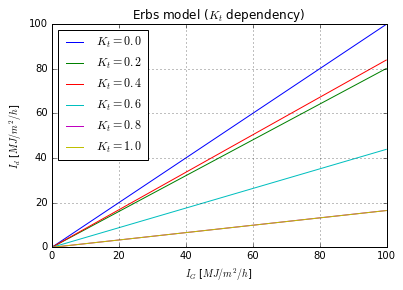

In [5]:
k = [0.9511, -0.1604, 4.388, -16.638, 12.336]

def get_Id(IG, Kt):
    if Kt <= 0.22: return IG * (1.0 - 0.99*Kt)
    elif Kt<=0.80: return IG * sum([k[i] * Kt**i for i in range(5)])
    else: return 0.165 * IG

for Kt in [i/5.0 for i in range(5+1)]:
    x = [x/10.0 for x in range(1000)]
    y = [get_Id(i, Kt) for i in x]
    plt.plot(x,y, label="$K_t={0}$".format(Kt))

plt.title("Erbs model ($K_t$ dependency)")
plt.xlabel("$I_G$ [$MJ/m^2/h$]")
plt.ylabel("$I_d$ [$MJ/m^2/h$]")
plt.grid()
plt.legend(loc="upper left")
plt.show()

### 晴天指数と大気外水平面日射量

晴天指数 $K_t$ は、大気外水平面日射量 $H_0$および全天日射量 $H$から求まります。これらの関係をプロットします。

ただし、大気外水平面日射量 $H_0$ は次の式で求まるものとします。

$H_0 = (1.00011 + 0.034211 cos \omega J + 0.001280 sin \omega J + 0.000719 cos 2 \omega J + 0.000077 sin 2 \omega J)^{0.5} $

ここで、

* $\omega = \cfrac{2 \pi}{365}$
* $J$ = 元日からの通算日数 + 0.5

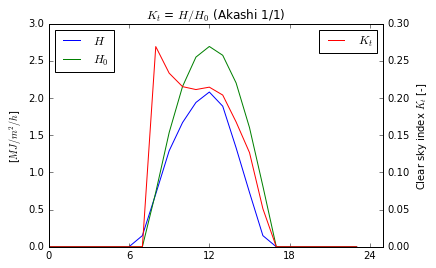

In [6]:
def get_H0(d, Ts, longtitude, latitude):
    h = get_h(d, Ts, longtitude, latitude)
    omega = 2.0 * pi / 365
    J = d + 0.5
    r = 1.0
    r_dash = (1.00011 + 0.034221 * cos(omega*J) + 0.001280*sin(omega*J)
                 +0.000719*cos(2.0*omega*J)+0.000077*sin(2.0*omega*J))**0.5
    distES = r/r_dash
    H0 = max(0, 1.367 / (distES**2) * sin(h*pi/180)) * 3.6
    return H0

def get_clearskyindex(H, d, Ts, longtitude, latitude):
    h = get_h(d, Ts, longtitude, latitude)
    H0 = get_H0(d, Ts, longtitude, latitude)* 3.6
    if H0 <= 0: return 0
    else: return H/H0

hours = [i/4 for i in range(24*4)]

ax = plt.gca()
ax.plot(hours, [data.J[h] for h in hours], label='$H$')
ax.plot(hours, [get_H0(ceil(h/24), h%24, 135, 35) for h in hours], label="$H_0$")
ax.set_ylabel("[$MJ/m^2/h$]")
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(hours, [get_clearskyindex(data.J[h], ceil(h/24), h%24, 135, 35) for h in hours], label="$K_t$", color='red')
ax2.set_ylabel("Clear sky index $K_t$ [-]")
ax2.legend(loc="upper right")

plt.title("$K_t$ = $H/H_0$ (Akashi 1/1)")
plt.xlabel("hour")
plt.xticks([0,6,12,18,24])
plt.show()

### 直散分離

ここまでで条件がそろったので、実際に直散分離する。


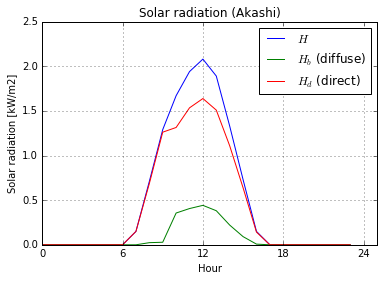

In [7]:
def split_H(H, d, Ts, longtitude, latitude):
    CSI = get_clearskyindex(H, d, Ts, longtitude, latitude)
    if CSI < 0.22:
        Hd = (1.0 - 0.99*CSI)*H
    elif CSI <= 0.80:
        Hd = (0.9511 - 0.1604*CSI + 4.388*CSI**2 - 16.638*CSI**3 + 12.366*CSI**4) * H
    else:
        Hd = 0.165 * H
    return H-Hd, Hd

hours = [i/4 for i in range(24*4)]
plt.plot(hours, [data.J[h] for h in hours], label='$H$')
plt.plot(hours, [split_H(data.J[h], ceil(h/24), h%24, 135, 35)[0] for h in hours], label='$H_b$ (diffuse)')
plt.plot(hours, [split_H(data.J[h], ceil(h/24), h%24, 135, 35)[1] for h in hours], label='$H_d$ (direct)')

plt.title("Solar radiation (Akashi)")
plt.xlabel("Hour")
plt.ylabel("Solar radiation [kW/m2]")
plt.xticks([0,6,12,18,24])
plt.grid()
plt.legend(loc="upper right")
plt.show()
